 # Pentagon Moduli Space VAE

This is a VAE model which is trained to generate sample from the configuration space of pentagons with predetermined sidelengths.

In [ ]:

import os

import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn import datasets
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Distribution, Uniform
from matplotlib import cm

#topological data analysis
!pip install ripser
!pip install persim
from ripser import ripser
from persim import plot_diagrams

# from pytorch_model_summary import summary

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.3/841.3 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.6/48.6 kB 3.7 MB/s eta 0:00:00
  Created wheel for hopcroftkarp: filename=hopcroftkarp-1.2.5-py2.py3-none-any.whl size=18104 sha256=4b39fab9f3d1fd745978f3d5e9e34886dd53ce6957d372baf74869061be90980
  Stored in directory: /root/.cache/pip/wheels/1f/cc/2d/de23a8b9ae586817b0b44de4a4b1a08f23473e248a644b312f
Successfully built hopcroftkarp


# Background Code

In [ ]:
# @title
data_dir = 'sample_data/'
if not(os.path.exists(data_dir)):
    os.mkdir(data_dir)
file_path = os.path.join(data_dir, 'sphere.txt')

def compute_energy(penta):
    angle_data = np.zeros((5,)) # internal angles

    for i in range(5):
        ii = (2*i -2)%10
        jj = (2*i - 1)%10
        u = penta[[ii, jj]]

        ii = (2*i)%10
        jj = (2*i + 1)%10
        v = penta[[ii , jj]]

        ii = (2*i + 2)%10
        jj = (2*i + 3)%10
        w = penta[[ii, jj]]

        z = np.sum((u - v)*(w-v))

        angle_data[i]  = np.arccos( np.minimum(z,1) )

    energy = np.sum((angle_data - (3/5)*np.pi)**2)
    return energy

def distance_check(input=None, name=None, mode='data', size=100000):
    # takes the name of a torch .model file or a numpy array shape (n,10)
    if mode=='model':
        model_best = torch.load(name + '.model', weights_only=False)
        samples=model_best.decoder.sample(torch.rand(size,L)).detach().numpy()
    elif mode=='data':
        samples=input
    suma, sumb, sumc, sumd, sume= [], [], [], [], []
    for id,i in enumerate(samples):
        x = i.reshape(5,2)
        suma.append(np.linalg.norm(x[0]-x[1]))
        sumb.append(np.linalg.norm(x[1]-x[2]))
        sumc.append(np.linalg.norm(x[2]-x[3]))
        sumd.append(np.linalg.norm(x[3]-x[4]))
        sume.append(np.linalg.norm(x[4]-x[0]))

    print('mean side lengths:',np.mean(suma),np.mean(sumb),np.mean(sumc),np.mean(sumd),np.mean(sume))
    print('std dev side lengths:',np.std(suma),np.std(sumb),np.std(sumc),np.std(sumd),np.std(sume))

class SphereDataset(Dataset):
    def __init__(self, file_path, mode='train'):
        if mode == 'train':
          self.data = np.loadtxt(file_path, delimiter=',')[:30000].astype(np.float32)
          self.energy = compute_energy(self.data)
        elif mode == 'val':
          self.data = np.loadtxt(file_path, delimiter=',')[30000:34303].astype(np.float32)
          self.energy = compute_energy(self.data)
        else:
          self.data = np.loadtxt(file_path, delimiter=',')[34303:].astype(np.float32)
          self.energy = compute_energy(self.data)


    def __len__(self):
        return self.data.shape[0]  # Number of samples

    def __getitem__(self, idx):
        return self.data[idx]


In [ ]:
# @title
PI = torch.from_numpy(np.asarray(np.pi))
EPS = 1.e-5

def log_categorical(x, p, num_classes=256, reduction=None, dim=None):
    x_one_hot = F.one_hot(x.long(), num_classes=num_classes)
    log_p = x_one_hot * torch.log(torch.clamp(p, EPS, 1. - EPS))
    if reduction == 'avg':
        return torch.mean(log_p, dim)
    elif reduction == 'sum':
        return torch.sum(log_p, dim)
    else:
        return log_p

def log_bernoulli(x, p, reduction=None, dim=None):
    pp = torch.clamp(p, EPS, 1. - EPS)
    log_p = x * torch.log(pp) + (1. - x) * torch.log(1. - pp)
    if reduction == 'avg':
        return torch.mean(log_p, dim)
    elif reduction == 'sum':
        return torch.sum(log_p, dim)
    else:
        return log_p

def log_normal_diag(x, mu, log_var, reduction=None, dim=None):
    D = x.shape[1]
    log_p = -0.5 * D * torch.log(2. * PI) - 0.5 * log_var - 0.5 * torch.exp(-log_var) * (x - mu)**2.
    if reduction == 'avg':
        return torch.mean(log_p, dim)
    elif reduction == 'sum':
        return torch.sum(log_p, dim)
    else:
        return log_p

def log_standard_normal(x, reduction=None, dim=None):
    D = x.shape[1]
    log_p = -0.5 * D * torch.log(2. * PI) - 0.5 * x**2.
    if reduction == 'avg':
        return torch.mean(log_p, dim)
    elif reduction == 'sum':
        return torch.sum(log_p, dim)
    else:
        return log_p

class CustomUniform(Distribution):
    def __init__(self, low, high, validate_args=False):
        super().__init__(validate_args=validate_args)
        self.low = low
        self.high = high
        self.uniform = Uniform(low, high)

    def sample(self, sample_shape=torch.Size()):
        return self.uniform.sample(sample_shape)

    def log_prob(self, value):
        # Create a mask for values inside the region
        in_bounds = (value >= self.low) & (value <= self.high)

        if value.ndim > 1:
            in_support = in_bounds.all(dim=-1)  # shape: (batch,)
        else:
            in_support = in_bounds  # 1D case

        # Create full result tensor of -inf
        log_prob = torch.full(
            in_support.shape, float('-inf'), dtype=torch.float32, device=value.device
        )

        # Set log-prob only for valid entries
        volume = torch.prod(self.high - self.low)
        log_prob[in_support] = -torch.log(volume)
        return log_prob

In [ ]:
# @title
class Encoder(nn.Module):
    def __init__(self, encoder_net):
        super(Encoder, self).__init__()

        self.encoder = encoder_net

    @staticmethod
    def reparameterization(mu, log_var):
        std = torch.exp(0.5*log_var)

        eps = torch.randn_like(std)

        return mu + std * eps

    def encode(self, x):
        h_e = self.encoder(x)
        mu_e, log_var_e = torch.chunk(h_e, 2, dim=1)

        return mu_e, log_var_e

    def sample(self, x=None, mu_e=None, log_var_e=None):
        if (mu_e is None) and (log_var_e is None):
            mu_e, log_var_e = self.encode(x)
        else:
            if (mu_e is None) or (log_var_e is None):
                raise ValueError('mu and log-var can`t be None!')
        z = self.reparameterization(mu_e, log_var_e)
        return z

    def log_prob(self, x=None, mu_e=None, log_var_e=None, z=None):
        if x is not None:
            mu_e, log_var_e = self.encode(x)
            z = self.sample(mu_e=mu_e, log_var_e=log_var_e)
        else:
            if (mu_e is None) or (log_var_e is None) or (z is None):
                raise ValueError('mu, log-var and z can`t be None!')

        return log_normal_diag(z, mu_e, log_var_e)

    def forward(self, x, type='log_prob'):
        assert type in ['encode', 'log_prob'], 'Type could be either encode or log_prob'
        if type == 'log_prob':
            return self.log_prob(x)
        else:
            return self.sample(x)


In [ ]:
# @title
class Decoder(nn.Module):
    def __init__(self, decoder_net, distribution='gaussian', num_vals=None):
        super(Decoder, self).__init__()

        self.decoder = decoder_net
        self.distribution = distribution
        self.num_vals=num_vals

    def decode(self, z):
        h_d = self.decoder(z)

        if self.distribution == 'categorical':
            b = h_d.shape[0]
            d = h_d.shape[1]//self.num_vals
            h_d = h_d.view(b, d, self.num_vals)
            mu_d = torch.softmax(h_d, 2)
            return [mu_d]

        elif self.distribution == 'bernoulli':
            mu_d = torch.sigmoid(h_d)
            return [mu_d]

        elif self.distribution == 'gaussian':
            mu_d, log_var_d = torch.chunk(h_d, 2, dim=1)
            return [mu_d, log_var_d]

        else:
            raise ValueError('Either `categorical`, `bernoulli`, or `gaussian`')

    def sample(self, z):
        outs = self.decode(z)
        x_new = None

        if self.distribution == 'categorical':
            mu_d = outs[0]
            b = mu_d.shape[0]
            m = mu_d.shape[1]
            mu_d = mu_d.view(mu_d.shape[0], -1, self.num_vals)
            p = mu_d.view(-1, self.num_vals)
            x_new = torch.multinomial(p, num_samples=1).view(b, m)

        elif self.distribution == 'bernoulli':
            mu_d = outs[0]
            x_new = torch.bernoulli(mu_d)

        elif self.distribution == 'gaussian':
            mu_d = outs[0]
            log_var_d = outs[1]
            x_new = torch.normal(mu_d, torch.exp(0.5*log_var_d))
            # x_new = self.reparameterization(mu_d, log_var_d)
        else:
            raise ValueError('Either `categorical`, `bernoulli`, or `gaussian`')

        return x_new

    # def reparameterization(mu, log_var):
    #     std = torch.exp(0.5*log_var)

    #     eps = torch.randn_like(std)

    #     return mu + std * eps

    def log_prob(self, x, z):
        outs = self.decode(z)

        if self.distribution == 'categorical':
            mu_d = outs[0]
            log_p = log_categorical(x, mu_d, num_classes=self.num_vals, reduction='sum', dim=-1).sum(-1)

        elif self.distribution == 'bernoulli':
            mu_d = outs[0]
            log_p = log_bernoulli(x, mu_d, reduction='sum', dim=-1)

        elif self.distribution == 'gaussian':
            mu_d = outs[0]
            log_var_d = outs[1]
            log_p = log_normal_diag(x, mu_d, log_var_d, reduction='sum', dim=-1)
        else:
            raise ValueError('Either `categorical`, `bernoulli`, or `gaussian`')

        return log_p

    def forward(self, z, x=None, type='log_prob'):
        assert type in ['decoder', 'log_prob'], 'Type could be either decode or log_prob'
        if type == 'log_prob':
            return self.log_prob(x, z)
        else:
            return self.sample(z)

In [ ]:
# @title
class Prior(nn.Module):
    def __init__(self, L):
        super(Prior, self).__init__()
        self.L = L

    def sample(self, batch_size):
        z = torch.randn((batch_size, self.L))
        return z

    def log_prob(self, z):
        return log_standard_normal(z)

In [ ]:
# @title
class VAE(nn.Module):
    def __init__(self, encoder_net, decoder_net, num_vals=256, L=16, likelihood_type='categorical'):
        super(VAE, self).__init__()

        print('VAE by JT.')

        self.encoder = Encoder(encoder_net=encoder_net)
        self.decoder = Decoder(distribution=likelihood_type, decoder_net=decoder_net, num_vals=num_vals)
        self.prior = Prior(L=L)

        self.num_vals = num_vals

        self.likelihood_type = likelihood_type

    def forward(self, x, reduction='avg'):
        # encoder
        mu_e, log_var_e = self.encoder.encode(x)
        z = self.encoder.sample(mu_e=mu_e, log_var_e=log_var_e)

        # ELBO
        RE = self.decoder.log_prob(x, z)
        KL = (self.prior.log_prob(z) - self.encoder.log_prob(mu_e=mu_e, log_var_e=log_var_e, z=z)).sum(-1)

        if reduction == 'sum':
            return -(RE + KL).sum()
        else:
            return -(RE + KL).mean()

    def sample(self, batch_size=64):
        z = self.prior.sample(batch_size=batch_size)
        return self.decoder.sample(z)

In [ ]:
# @title
def evaluation(test_loader, name=None, model_best=None, epoch=None):
    # EVALUATION
    if model_best is None:
        # load best performing model
        model_best = torch.load(name + '.model', weights_only=False)

    model_best.eval()
    loss = 0.
    N = 0.
    for indx_batch, test_batch in enumerate(test_loader):
        loss_t = model_best.forward(test_batch, reduction='sum')
        loss = loss + loss_t.item()
        N = N + test_batch.shape[0]
    loss = loss / N

    if epoch is None:
        print(f'FINAL LOSS: nll={loss}')
    else:
        print(f'Epoch: {epoch}, val nll={loss}')

    return loss


def samples_real(name, test_loader):
    # REAL-------
    num_x = 4
    num_y = 4
    x = next(iter(test_loader)).detach().numpy()

    fig, ax = plt.subplots(num_x, num_y)
    for i, ax in enumerate(ax.flatten()):
        plottable_image = np.reshape(x[i], (5, 2)).T
        ax.plot(x[0,range(-1,5)], x[1,range(-1,5)] , '-o', c= cm.magma(compute_energy(x)/np.max(energy)))
        ax.axis('off')

    plt.savefig(name+'_real_images.pdf', bbox_inches='tight')
    plt.close()


def samples_generated(name, data_loader, extra_name=''):
    x = next(iter(data_loader)).detach().numpy()

    # GENERATIONS-------
    model_best = torch.load(name + '.model', weights_only=False)
    model_best.eval()

    num_x = 4
    num_y = 4
    x = model_best.sample(num_x * num_y)
    x = x.detach().numpy()

    fig, ax = plt.subplots(num_x, num_y)
    for i, ax in enumerate(ax.flatten()):
        plottable_image = np.reshape(x[i], (5, 2)).T
        ax.plot(x[0,range(-1,5)], x[1,range(-1,5)] , '-o', c= cm.magma(compute_energy(x)/np.max(compute_energy(x))))
        ax.axis('off')


    plt.savefig(name + '_generated_images' + extra_name + '.pdf', bbox_inches='tight')
    plt.close()


def plot_curve(name, nll_val, mode='show'):
    plt.plot(np.arange(len(nll_val)), nll_val, linewidth='3')
    plt.xlabel('epochs')
    plt.ylabel('nll')
    plt.savefig(name + '_nll_val_curve.pdf', bbox_inches='tight')
    if mode == 'show':
        plt.show()
    plt.close()

def path_test(name, path=torch.stack((torch.linspace(0,1,60),torch.linspace(0,1,60)),axis=1)):
    model_best = torch.load(name + '.model', weights_only=False)
    samples=model_best.decoder.sample(path).detach().numpy()
    plt.figure(figsize=(14,6))
    for id,i in enumerate(samples):
        x = i.reshape(5,2).T
        cent = np.mean(x,axis=1)
        plt.subplot(6,10,id+1)
        plt.plot(x[0,range(-1,5)], x[1,range(-1,5)] , '-o', c= cm.magma(compute_energy(i)/np.max(energy)))
        plt.axis('square')
        plt.axis('off')
        plt.xlim(cent[0]-1.3,cent[0]+1.3);
        plt.ylim(cent[1]-1.3,cent[1]+1.3);
def latent_coloring(name, step_size=0.01):
    latentgrid=torch.tensor(np.asarray(np.meshgrid(np.arange(0,1,step=step_size), np.arange(0,1,step_size)))).reshape(2,-1).T.type(torch.float32)
    model_best = torch.load(name + '.model', weights_only=False)
    colorify= lambda t: compute_energy(t)/np.max(energy)
    latentsample=model_best.decoder.sample(latentgrid).detach().numpy()
    latentcolors=np.asarray([colorify(x) for x in latentsample])
    plt.figure(figsize=(14,6))
    plt.scatter(latentgrid[:,0], latentgrid[:,1], s=1, marker='o', c=cm.magma(latentcolors))
    plt.axis('square')
    plt.xlim(0,1)
    plt.ylim(0,1)


In [ ]:
# @title
def training(name, max_patience, num_epochs, model, optimizer, training_loader, val_loader):
    nll_val = []
    best_nll = 1000.
    patience = 0

    # Main loop
    try:
        for e in range(num_epochs):
            # TRAINING
            model.train()
            for indx_batch, batch in enumerate(training_loader):
                if hasattr(model, 'dequantization'):
                    if model.dequantization:
                        batch = batch + torch.rand(batch.shape)
                loss = model.forward(batch)

                optimizer.zero_grad()
                loss.backward(retain_graph=True)
                optimizer.step()

            # Validation
            loss_val = evaluation(val_loader, model_best=model, epoch=e)
            nll_val.append(loss_val)  # save for plotting

            if e == 0:
                print('saved!')
                torch.save(model, name + '.model')
                best_nll = loss_val
            else:
                if loss_val < best_nll:
                    print('saved!')
                    torch.save(model, name + '.model')
                    best_nll = loss_val
                    patience = 0

                    # samples_generated(name, val_loader, extra_name="_epoch_" + str(e))
                else:
                    patience = patience + 1

            if patience > max_patience:
                break
    except KeyboardInterrupt:
        return np.asarray(nll_val)
    nll_val = np.asarray(nll_val)

    return nll_val

# Loading the dataset

In [ ]:
train_data = SphereDataset(file_path, mode='train')
val_data = SphereDataset(file_path, mode='val')
test_data = SphereDataset(file_path, mode='test')

training_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=True)

result_dir = 'results/'
if not(os.path.exists(result_dir)):
    os.mkdir(result_dir)
name = 'vae'

**Some pictures of pentagons. The coloring is an "energy" based on the sum of the internal angles.**

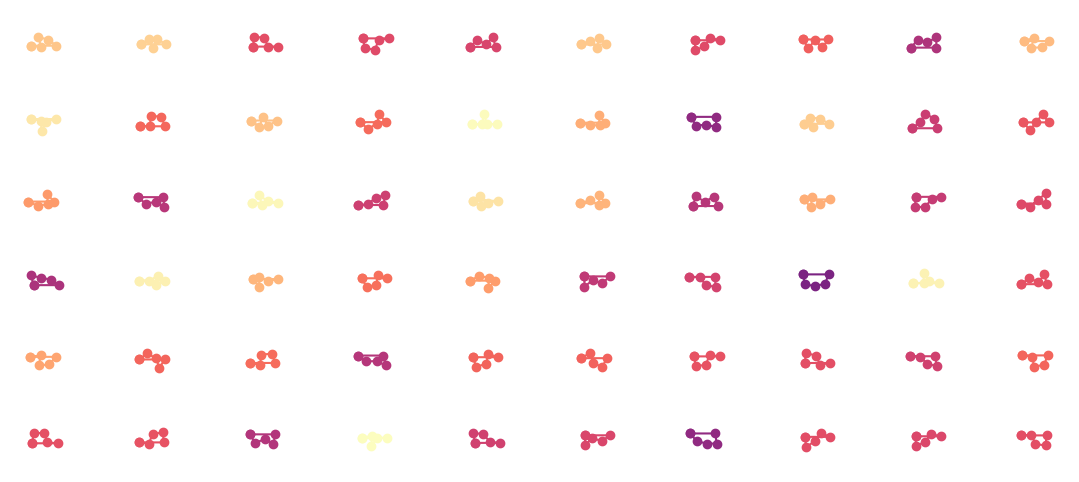

In [ ]:
energy=[]
for i in train_data:
  energy.append(compute_energy(i))
energy=np.asarray(energy)

plt.figure(figsize=(14,6))
for i in range(60):
    ind = np.random.randint(0, train_data.data.shape[0])
    x = train_data[ind].reshape(5,2).T
    cent = np.mean(x,axis=1)
    plt.subplot(6,10,i+1)
    plt.plot(x[0,range(-1,5)], x[1,range(-1,5)] , '-o', c= cm.magma(energy[ind]/np.max(energy)))
    plt.axis('square')
    plt.axis('off')
    plt.xlim(cent[0]-1.3,cent[0]+1.3);
    plt.ylim(cent[1]-1.3,cent[1]+1.3);

**We can see that each pentagon has 4 sides of length 0.4 and one side of length 1.**

In [ ]:
distance_check(input=train_data.data, mode='data')

mean side lengths: 0.4 0.4 0.4 0.40000004 1.0
std dev side lengths: 1.5096575e-08 2.35193e-08 1.784493e-08 3.2496832e-08 0.0


# Setting Up the VAE

In [ ]:
D = 10   # input dimension
L = 2  # number of latents
M = 150  # the number of neurons in scale (s) and translation (t) nets

lr = 1e-3 # learning rate
num_epochs = 1000 # max. number of epochs
max_patience = 30 # an early stopping is used, if training doesn't improve for longer than 20 epochs, it is stopped

In [ ]:
# likelihood_type = 'categorical'

# if likelihood_type == 'categorical':
#     num_vals = 17
# elif likelihood_type == 'bernoulli':
#     num_vals = 1
likelihood_type = 'gaussian'
num_vals = 2

encoder = nn.Sequential(nn.Linear(D, M), nn.LeakyReLU(),
                        nn.Linear(M, M), nn.LeakyReLU(),
                        nn.Linear(M, 2 * L))

decoder = nn.Sequential(nn.Linear(L, M), nn.LeakyReLU(),
                        nn.Linear(M, M), nn.LeakyReLU(),
                        nn.Linear(M, num_vals * D))

# prior = torch.distributions.MultivariateNormal(torch.zeros(L), torch.eye(L))
prior = CustomUniform(torch.zeros(L), torch.ones(L))
model = VAE(encoder_net=encoder, decoder_net=decoder, num_vals=num_vals, L=L, likelihood_type=likelihood_type)

# Print the summary (like in Keras)
# print("ENCODER:\n", summary(encoder, torch.zeros(1, D), show_input=False, show_hierarchical=False))
# print("\nDECODER:\n", summary(decoder, torch.zeros(1, L), show_input=False, show_hierarchical=False))

VAE by JT.


In [ ]:
# OPTIMIZER
optimizer = torch.optim.Adamax([p for p in model.parameters() if p.requires_grad == True], lr=lr)

# Training the VAE

In [ ]:

# Training procedure
nll_val = training(name=result_dir + name, max_patience=max_patience, num_epochs=num_epochs, model=model, optimizer=optimizer,
                       training_loader=training_loader, val_loader=val_loader)

Epoch: 0, val nll=76.3780840129706
saved!
Epoch: 1, val nll=68.64538733083205
saved!
Epoch: 2, val nll=66.64644565178908
saved!
Epoch: 3, val nll=65.66439360472981
saved!
Epoch: 4, val nll=65.06291259368464
saved!
Epoch: 5, val nll=64.8976561847521
saved!
Epoch: 6, val nll=64.12670986380323
saved!
Epoch: 7, val nll=63.05146839550532
saved!
Epoch: 8, val nll=62.77764420240058
saved!
Epoch: 9, val nll=62.500477614636594
saved!
Epoch: 10, val nll=65.447443482268
Epoch: 11, val nll=62.30840621902143
saved!
Epoch: 12, val nll=63.582255915544934
Epoch: 13, val nll=61.130002102684536
saved!
Epoch: 14, val nll=61.6630709162984
Epoch: 15, val nll=65.60894469009176
Epoch: 16, val nll=60.60385634670306
saved!
Epoch: 17, val nll=60.86286116699105
Epoch: 18, val nll=60.77666520019645
Epoch: 19, val nll=60.31958456037212
saved!
Epoch: 20, val nll=60.372659713812496
Epoch: 21, val nll=62.54036340130614
Epoch: 22, val nll=59.871521520913824
saved!
Epoch: 23, val nll=59.14675508286824
saved!
Epoch: 24,

FINAL LOSS: nll=52.958490692138675


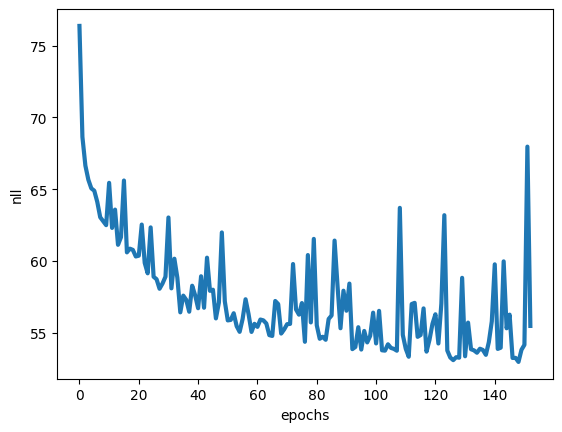

In [ ]:
test_loss = evaluation(name=result_dir + name, test_loader=test_loader)
f = open(result_dir + name + '_test_loss.txt', "w")
f.write(str(test_loss))
f.close()

samples_real(result_dir + name, test_loader)

plot_curve(result_dir + name, nll_val)

# Model Analysis

**Checking the mean side lengths of pentagons generated by our model.**

In [ ]:
distance_check(name=result_dir + name, mode='model')

mean side lengths: 0.37784868 0.41131663 0.34893566 0.40150094 1.000803
std dev side lengths: 0.12724198 0.1656496 0.13218547 0.0032514234 0.0015153993


**Mapping out the colorings of pentagons associated to points in our latent space.**

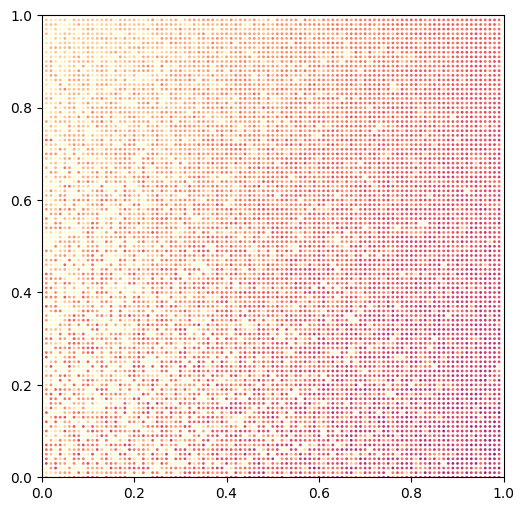

In [ ]:
latent_coloring(name=result_dir + name)

**Checking if our model can take in a path in the latent space and output a path in the data. We are looking for a continuous deformation of a pentagon.**

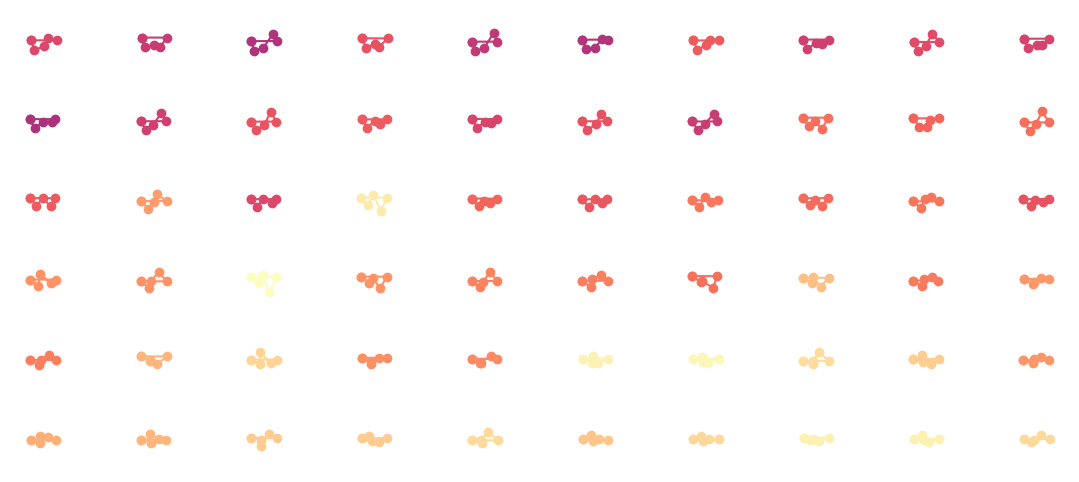

In [ ]:
path_test(name=result_dir + name, path=torch.stack((torch.linspace(0,1,60).flip(0),torch.linspace(0,1,60)),axis=1))

# Topological Data Analysis

**If the data is a sphere we want 1 persistent H2 class and no H1 classes.**

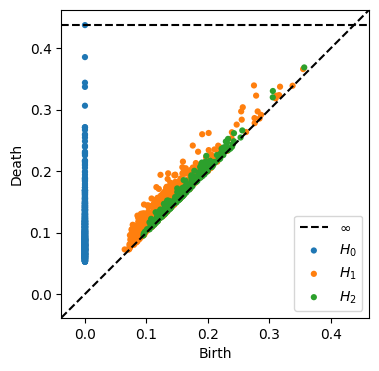

In [ ]:
model_best = torch.load(result_dir + name + '.model', weights_only=False)
sample=model_best.decoder.sample(torch.rand(1000,L)).detach().numpy()
n_land = 900
res = ripser(sample, n_perm = n_land, maxdim=2, coeff =13, thresh = 1.8)
dgms = res['dgms']
plt.figure(figsize = (4,4))
plot_diagrams(dgms)

In [ ]:
pers1 = dgms[1][:,1] - dgms[1][:,0]
pers2 = dgms[2][:,1] - dgms[2][:,0]

pers1_sorted = np.sort(pers1)[::-1]
pers2_sorted = np.sort(pers2[pers2 < np.inf])[::-1]
print('Sphere')
print('Persistence of top 10 1-d features:\n', np.around(pers1_sorted[0:10],decimals=2), '\n')
print('Persistence of top 10 2-d features:\n', np.around(pers2_sorted[0:10],decimals=2))

Sphere
Persistence of top 10 1-d features:
 [0.07 0.07 0.07 0.06 0.06 0.06 0.06 0.06 0.05 0.05] 

Persistence of top 10 2-d features:
 [0.03 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02]
